## Downloading database

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-16 02:39:26--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.166.192, 54.231.138.216, 54.231.235.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.166.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  21.2MB/s    in 0.6s    

2023-11-16 02:39:27 (21.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


## Libraries to use

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint

## Preparing data to use

In [4]:
data = pd.read_csv("jena_climate_2009_2016.csv")
# data.shape
data.head()
# data.describe()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
# for univariate LSTM

# extract temperature feature as DataFrame so that shape is as required by LSTM layer (layer, sequence_lenght, feature)
temperature = data[['T (degC)']]
print(temperature.shape)
temperature.head()

(420451, 1)


,T (degC)
0,-8.02
1,-8.41
2,-8.51
3,-8.31
4,-8.27


In [8]:
# for multivariate LSTM

features = data.loc[:, ['p (mbar)', 'rh (%)', 'H2OC (mmol/mol)', 'rho (g/m**3)']]
print(features.shape)
features.head()

(420451, 4)


,p (mbar),rh (%),H2OC (mmol/mol),rho (g/m**3)
0,996.52,93.3,3.12,1307.75
1,996.57,93.4,3.03,1309.80
2,996.53,93.9,3.02,1310.24
3,996.51,94.2,3.08,1309.19
4,996.51,94.1,3.09,1309.00


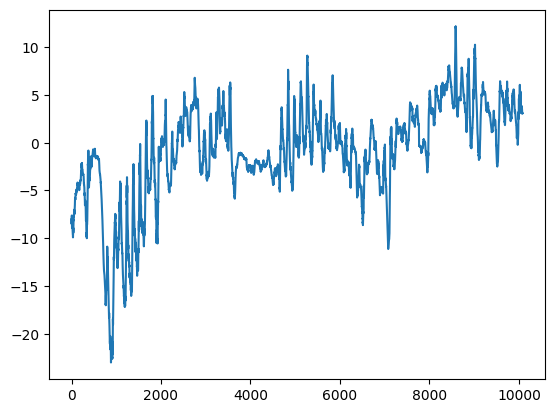

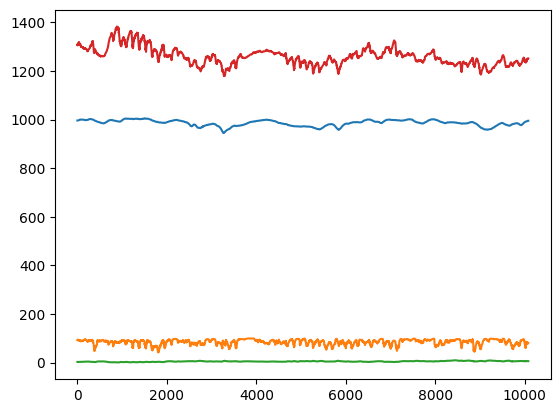

In [9]:
# One week of data plotted
plt.plot(range(1440*7), temperature[:1440*7])
plt.show()
plt.plot(range(1440*7), features[:1440*7])
plt.show()

### Definition of Train, Validation and Test datasets

For data segmentation

In [10]:
num_train_samples = len(data)//2
num_val_samples = len(data)//4
num_test_samples = num_val_samples

Univariate timeseries

In [11]:
utrain_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data = temperature[:-130],
    targets = temperature[130:],
    sequence_length = 120,
    batch_size = 64,
    start_index = 0,
    end_index = num_train_samples)

In [ ]:
uval_dataset = keras.utils.timeseries_dataset_from_array(
    data = temperature[:-130],
    targets = temperature[130:],
    sequence_length = 120,
    batch_size = 64,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

Multivariate timeseries

In [ ]:
mtrain_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data = features[:-130],
    targets = temperature[130:],
    sequence_length = 120,
    batch_size = 64,
    start_index = 0,
    end_index = num_train_samples)

In [ ]:
mval_dataset = keras.utils.timeseries_dataset_from_array(
    data = features[:-130],
    targets = temperature[130:],
    sequence_length = 120,
    batch_size = 64,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

## Using LSTM layer for the timeseries neural network

In [ ]:
lr = 0.001
epochs = 10

In [ ]:
for batch in utrain_dataset.take(1):
    uinputs, utargets = batch

print('Univariate')
print("Input shape:", uinputs.shape, '\nTarget shape:', utargets.shape, '\n')

for batch in mtrain_dataset.take(1):
    minputs, mtargets = batch

print('Multivariate')
print("Input shape:", minputs.shape, '\nTarget shape:', mtargets.shape)

Univariate
Input shape: (64, 120, 1) 
Target shape: (64, 1) 

Multivariate
Input shape: (64, 120, 4) 
Target shape: (64, 1)


In [ ]:
model = Sequential()
model.add(LSTM(16, input_shape=(uinputs.shape[1], uinputs.shape[2])))  # (sequence_lenght=120 , features(temperature)=1)
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1152      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint('BestModel.hdf5', monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(utrain_dataset, epochs=epochs, validation_data=uval_dataset, callbacks=[checkpoint])

Epoch 1/10
3283/3283 [==============================] - 66s 20ms/step - loss: 2.3841 - val_loss: 1.3030
Epoch 2/10
   9/3283 [..............................] - ETA: 45s - loss: 0.7437

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3283/3283 [==============================] - 57s 17ms/step - loss: 1.1351 - val_loss: 1.2392
Epoch 3/10
3283/3283 [==============================] - 58s 18ms/step - loss: 1.0215 - val_loss: 1.1971
Epoch 4/10
3283/3283 [==============================] - 57s 17ms/step - loss: 0.9806 - val_loss: 1.1863
Epoch 5/10
3283/3283 [==============================] - 62s 19ms/step - loss: 0.9553 - val_loss: 1.1951
Epoch 6/10
3283/3283 [==============================] - 58s 18ms/step - loss: 0.9353 - val_loss: 1.2005
Epoch 7/10
3283/3283 [==============================] - 57s 17ms/step - loss: 0.9236 - val_loss: 1.0639
Epoch 8/10
3283/3283 [==============================] - 58s 18ms/step - loss: 0.8956 - val_loss: 1.0432
Epoch 9/10
3283/3283 [==============================] - 57s 17ms/step - loss: 0.8804 - val_loss: 1.0279
Epoch 10/10
3283/3283 [==============================] - 60s 18ms/step - loss: 0.8687 - val_loss: 1.0038


In [ ]:
model2 = Sequential()
model2.add(LSTM(16, input_shape=(minputs.shape[1], minputs.shape[2])))  # (sequence_lenght=120 , features=4)
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mae')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 16)                1344      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1361 (5.32 KB)
Trainable params: 1361 (5.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checkpoint2 = ModelCheckpoint('BestModel2.hdf5', monitor='val_loss', save_best_only=True, mode='min')
history2 = model2.fit(mtrain_dataset, epochs=epochs, validation_data=mval_dataset, callbacks=[checkpoint2])

Epoch 1/10
3283/3283 [==============================] - 65s 19ms/step - loss: 7.5864 - val_loss: 6.6537
Epoch 2/10
   9/3283 [..............................] - ETA: 44s - loss: 12.2839

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3283/3283 [==============================] - 60s 18ms/step - loss: 7.1012 - val_loss: 6.5969
Epoch 3/10
3283/3283 [==============================] - 60s 18ms/step - loss: 7.1050 - val_loss: 6.5921
Epoch 4/10
3283/3283 [==============================] - 59s 18ms/step - loss: 7.1053 - val_loss: 6.5882
Epoch 5/10
3283/3283 [==============================] - 63s 19ms/step - loss: 7.1009 - val_loss: 6.5903
Epoch 6/10
3283/3283 [==============================] - 59s 18ms/step - loss: 7.1008 - val_loss: 6.5905
Epoch 7/10
3283/3283 [==============================] - 58s 18ms/step - loss: 7.1007 - val_loss: 6.5905
Epoch 8/10
3283/3283 [==============================] - 63s 19ms/step - loss: 7.1007 - val_loss: 6.5905
Epoch 9/10
3283/3283 [==============================] - 61s 19ms/step - loss: 7.1008 - val_loss: 6.5905
Epoch 10/10
3283/3283 [==============================] - 66s 20ms/step - loss: 7.1007 - val_loss: 6.5905
